# Definition of models

We consider a graph colouring problem including three colours corresponding respectively to :
* 0 : None edge
* 1 : intra-organisational edge
* 2 : inter-organisational edge

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
from statsmodels.graphics.tsaplots import plot_acf
from math import exp

In [25]:
def print_config(data):
        if not isinstance(data, list):
            for k, v in data.items():
                if k != 'posteriors':
                    print("{} => {}".format(k, v))
                    
def extract_strauss_from_file(path):
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    if not isinstance(data, list):
        print_config(data)
        data = data['posteriors']
    theta_l0 = [d[0] for d in data]
    theta_l1 = [d[1] for d in data]
    theta_l2 = [d[2] for d in data]
    beta = [d[3] for d in data]

    
    data_frame = pd.DataFrame({'theta_l0': theta_l0,
                               'theta_l1': theta_l1,
                               'theta_l2': theta_l2,
                               'beta': beta
                              })
    
    return data_frame

def extract_strauss_inter_from_file(path):
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    if not isinstance(data, list):
        print_config(data)
        data = data['posteriors']
    beta_01 = [d[0] for d in data]
    beta_02 = [d[1] for d in data]
    beta_12 = [d[2] for d in data]

    
    data_frame = pd.DataFrame({'beta_01': beta_01,
                               'beta_02': beta_02,
                               'beta_12': beta_12})
    
    return data_frame


def summary(data):
    col_names = data.columns.values
    for i in [25,50,75]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.percentile(data[param_name], i)
            print("Q{} for {} parameter {}".format(i, param_name, q))
    
    
def plot_marginals(data_abc, perfect_vals, burn_in=0, by=1):
    
    col_names = data_abc.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,25))
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
        params = data_abc[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=axs[i, 0])
        axs[i, 0].axvline(perfect_vals[i], color='r', linestyle='--', label='expected value')

        # Path
        axs[i, 1].plot(range(len(params)), params)
        axs[i, 1].axhline(perfect_vals[i], color='r', linestyle='--', label='expected value')
        axs[i, 1].set(xlabel='iterations', ylabel='{} parameter ABC'.format(param_name))


def autocor(data_abc, burn_in=0, by=1):

    col_names = data_abc.columns.values
    fig, axs = plt.subplots(len(col_names), 1, sharex='col', sharey='row', figsize=(14,21)) 
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        params = data_abc[param_name].tolist()[burn_in::by]
    
        plot_acf(params, ax=axs[i])
        axs[i].set_title("Autocorrelation for {} parameter".format(param_name))

## Strauss's model (with densities)

$$U(y) = \theta_{0} \sum_{i} \mathbb{1}\{y_i = 0\} + \theta_{1} \sum_{i} \mathbb{1}\{y_i = 1\} + \theta_{0} \sum_{i} \mathbb{1}\{y_i = 2\} + \beta \sum_{i \sim j} \mathbb{1}\{y_i \neq y_j\} $$

In [12]:
FILE_NAME_STRAUSS = 'assets/strauss.json'
data_strauss = extract_strauss_from_file(FILE_NAME_STRAUSS)

algo => abc_shadow
model => strauss_graph
theta0 => [4.8, 2.6, 5.0, 1.0]
theta_perf => [4.8, 2.6, 5.0, 1.0]
iters => 1000000
n => 200
delta => [0.01, 0.01, 0.01, 0.01]
y_obs => [16.4709, 11.6218, 16.9073, 258.7269]


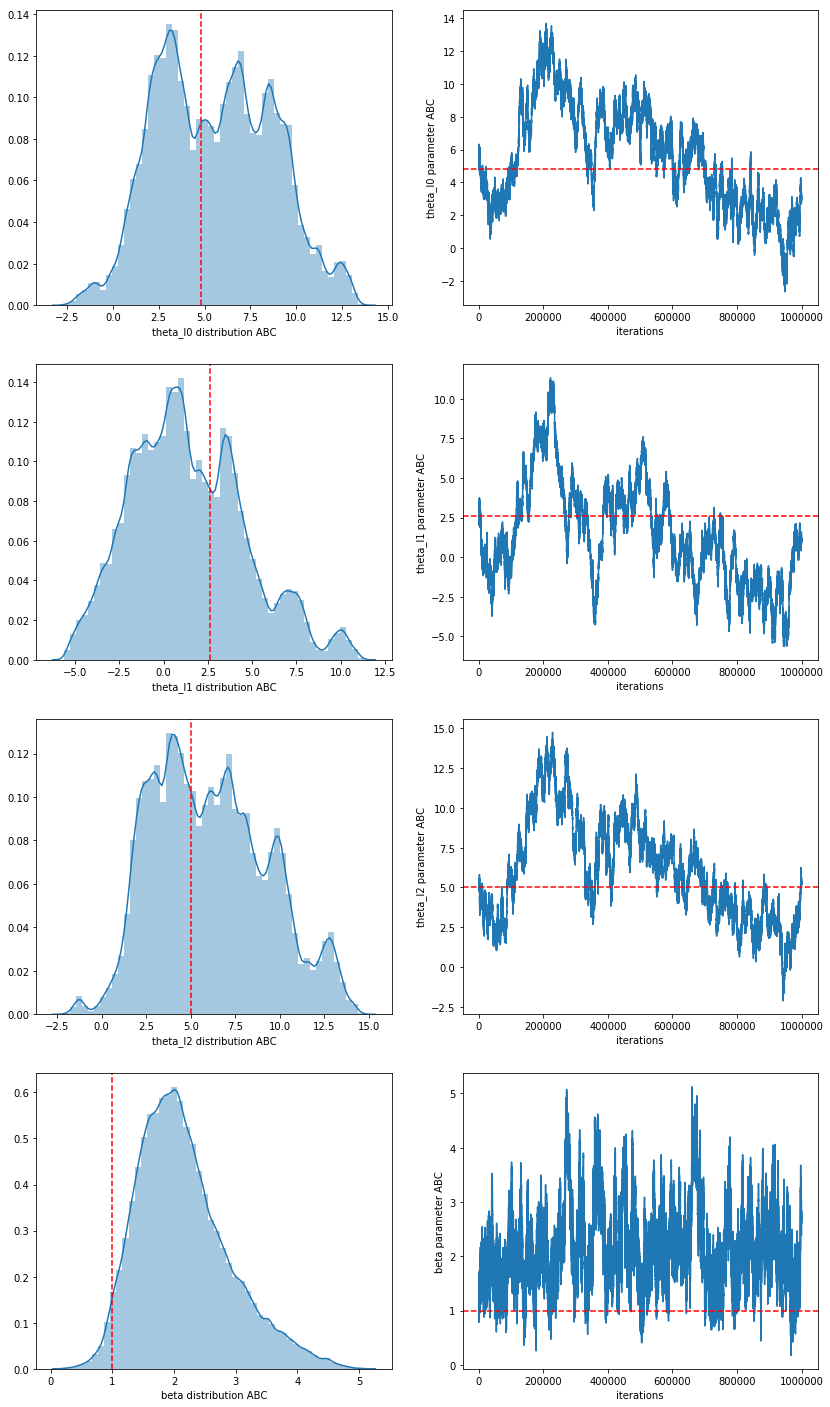

In [22]:
plot_marginals(data_strauss, [4.8, 2.6, 5.0, 1.0])

### Observations:
* Sampling of density parameters ($\theta$) is not satifactory
* By contrast, the sampling of the interaction parameter $\beta$ converges quite closed to the expected value

### Explanation
For different values of the density parameters $\theta$, we obtain a very similar observations.

#### Gaetan, C., & Guyon, X. (2008). Modélisation et statistique spatiales. New York: Springer (P.63) :
> S’il y a échangeabilité des K modalités, c-à-d si pour tout $k\neq l$,$\alpha_k \equiv \alpha$ et $\beta_{kl} \equiv \beta$,le modèle dépendra du seul paramètre d’interaction $\beta$ :
 $$\pi(x) = Z^{−1} exp{−\beta n(x)}$$
> où $n(x)$ est le nombre de paires de sites voisins de même modalité ; en effet
$\sum \alpha_k n_k \equiv \alpha n$ est une constante indépendante de $x$ et $\sum_{k < l} \beta_{kl}n_{kl} \equiv \beta(N − n(x))$ où $N$, le nombre total d’arêtes du graphe de voisinage, ne dépend pas de la réalisation $x$. 

## Strauss's model with interactions

$$U(y) = \beta_{01} \sum_{i \sim j} \mathbb{1}\{y_i = 0, y_j =1\} + \beta_{02} \sum_{i \sim j} \mathbb{1}\{y_i = 0, y_j=2\} + \beta_{12} \sum_{i \sim j} \mathbb{1}\{y_i = 1, y_j = 2\}$$


In [26]:
FILE_NAME_STRAUSS_INTER = 'assets/strauss_inter.json'
data_strauss_inter = extract_strauss_inter_from_file(FILE_NAME_STRAUSS_INTER)

algo => abc_shadow
model => strauss_inter_graph
theta0 => [0.5, -0.1, 0.5]
theta_perf => [0.5, -0.1, 0.5]
iters => 200000
n => 100
delta => [0.01, 0.01, 0.01]
y_obs => [97.31631631631632, 41.18018018018018, 98.13513513513513]


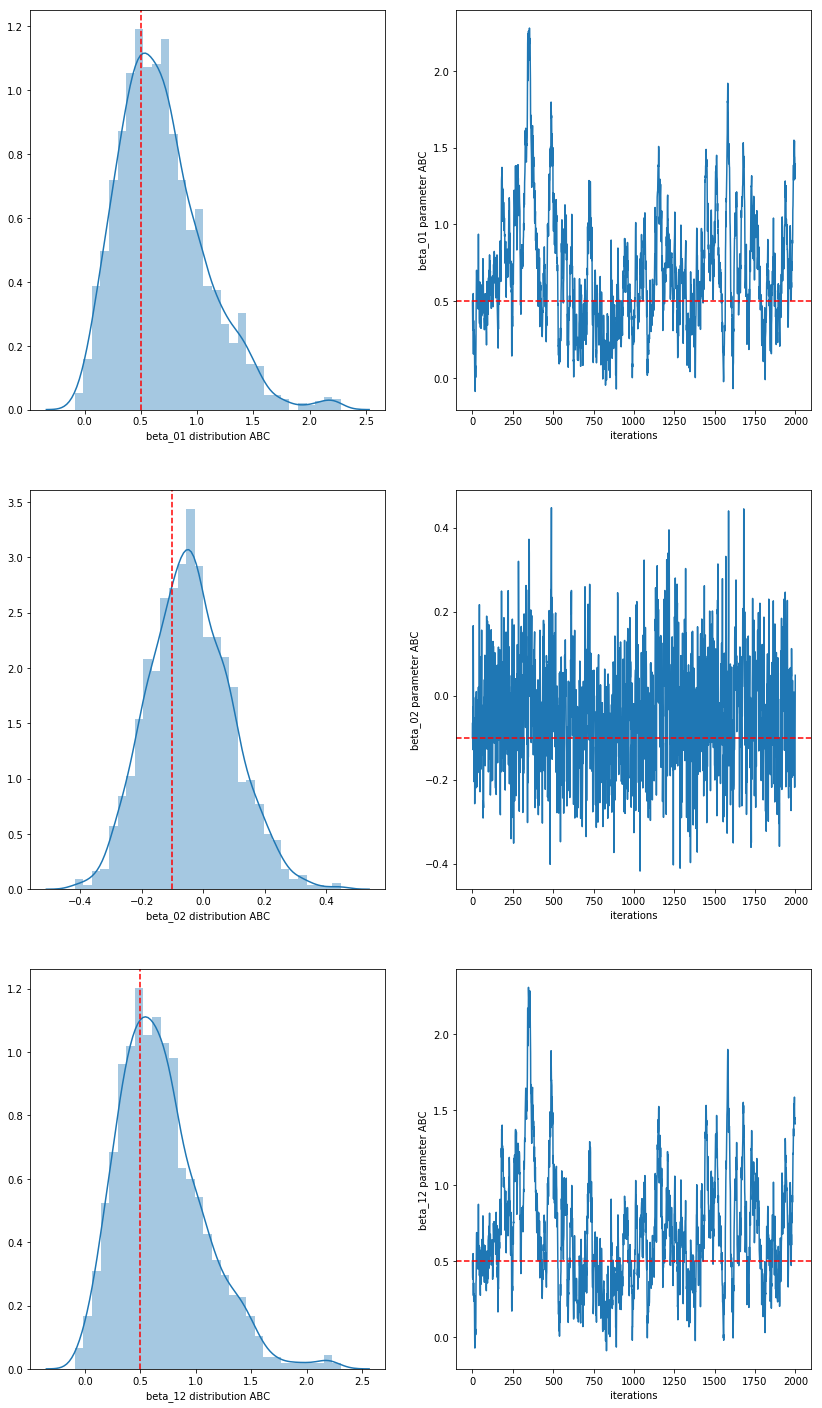

In [28]:
plot_marginals(data_strauss_inter, [0.5, -0.1, 0.5], by=100)

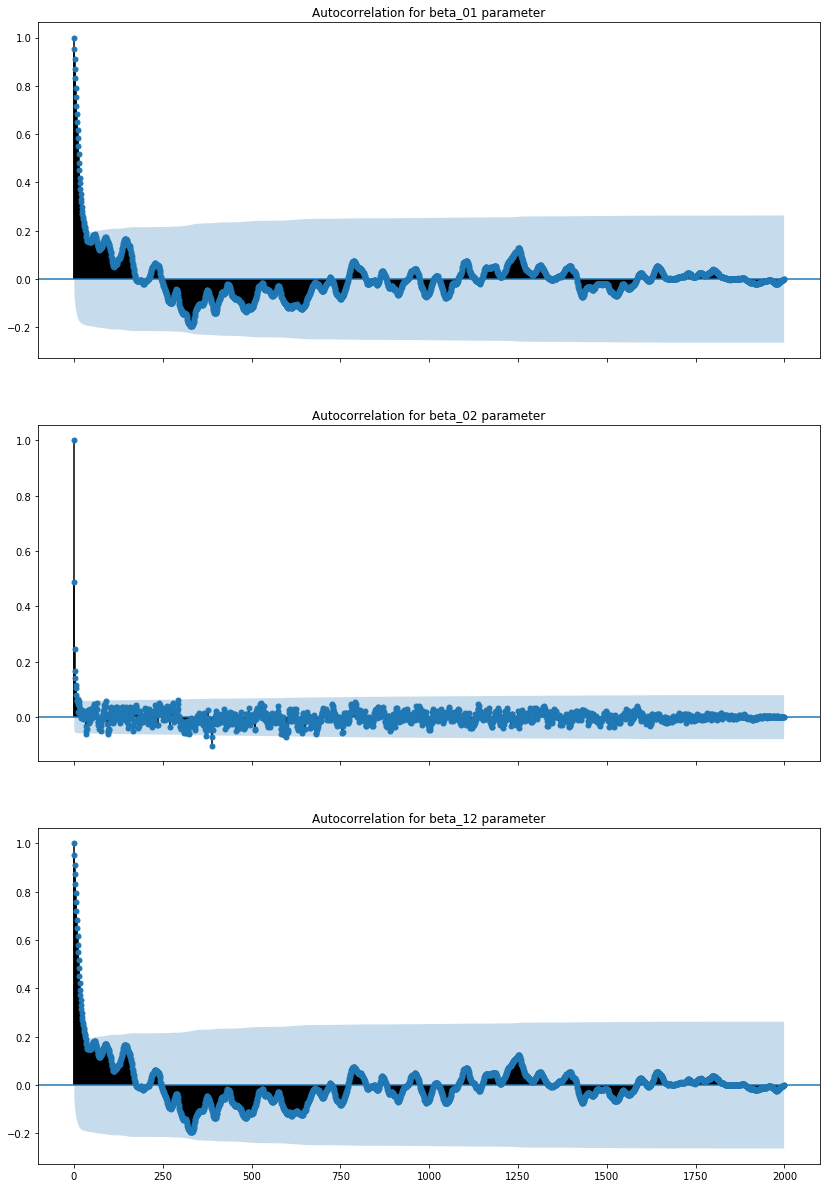

In [30]:
autocor(data_strauss_inter, by=100)